In [119]:
import math
import matplotlib
import matplotlib.dates as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from datetime import datetime
from numpy import *
import scipy.stats as stats
from tqdm import tqdm_notebook,tnrange

In [120]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [121]:
def ols_reg(x, y):
    result = stats.linregress(y, x)
    resid = y - result[0] * x - result[1]
    if ts.adfuller(resid)[1] <= 0.05:
        adf_r = 1
    else:
        adf_r = 0
    return adf_r, result[0], result[1], resid

In [122]:
'''
EG两步检验
'''
def cointegration_test2(y, x):
    # 线性回归并取残差
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    residual = ols_result.resid
    # ADF进行单位根检验   
    return ts.adfuller(residual)

'''
获取两个序列回归后的残差
'''
def get_residual(y, x):
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    residual= ols_result.resid
    return(residual)

def get_params(y, x):
    ols_result = sm.OLS(y,sm.add_constant(x)).fit()
    return ols_result.params
'''
计算偏离均值程度
'''
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [123]:
def data_clean(df):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df = df.drop(df[(df.hour == 9) & (df.minute < 30)].index)
    df = df.drop(df[(df.hour == 15) & (df.minute > 0)].index)
    df = df.drop(df[(df.hour == 11) & (df.minute > 30)].index)
    df = df.drop(df[(df.hour == 12)].index)
    df = df.drop(df[(df.hour == 1) & (df.minute < 30)].index)
    df = df.drop(df[(df.hour < 9) & (df.hour > 0)].index)
    df = df.drop(df[(df.hour < 24) & (df.hour > 15)].index)
    return df

In [136]:
# 获取2019-01-01-2020-12-31期间2年期、5年期、10年期国债期货主力连结历史数据
df2 = pd.read_csv('2年期国债期货价格分钟级数据.csv',index_col=0)
df5 = pd.read_csv('5年期国债期货价格分钟级数据.csv',index_col=0)
df10 = pd.read_csv('10年期国债期货价格分钟级数据.csv',index_col=0)
df2.index = pd.to_datetime(df2.index)
df5.index = pd.to_datetime(df5.index)
df10.index = pd.to_datetime(df10.index)
df2 = data_clean(df2)
df5 = data_clean(df5)
df10 = data_clean(df10)

In [137]:
df2 = df2.loc['2020-01-01 09:30:00':'2020-12-31 15:00:00']
df5 = df5.loc['2020-01-01 09:30:00':'2020-12-31 15:00:00']
df10 = df10.loc['2020-01-01 09:30:00':'2020-12-31 15:00:00']

In [138]:
# 输出备用
#df2.to_csv("2年期国债期货价格分钟级数据.csv")
#df5.to_csv("5年期国债期货价格分钟级数据.csv")
#df10.to_csv("10年期国债期货价格分钟级数据.csv")

# 一阶差分
n=1
df2_diff = df2.diff(periods=n).dropna()
df5_diff = df5.diff(periods=n).dropna()
df10_diff = df10.diff(periods=n).dropna()

In [139]:
# 训练集中开盘价的时间序列
ay_close2 = np.array(df2['close'])
ay_close5 = np.array(df5['close'])
ay_close10 = np.array(df10['close'])

# 训练集中一阶差分时间序列
ay_close2_diff = np.array(df2_diff['close'])
ay_close5_diff = np.array(df5_diff['close'])
ay_close10_diff = np.array(df10_diff['close'])

<module 'matplotlib.pyplot' from 'D:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

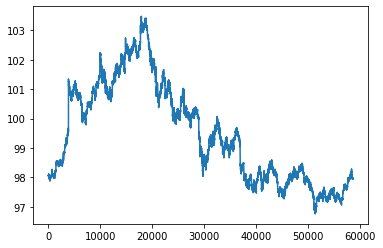

In [140]:
plt.plot(ay_close2)
plt

<AxesSubplot:>

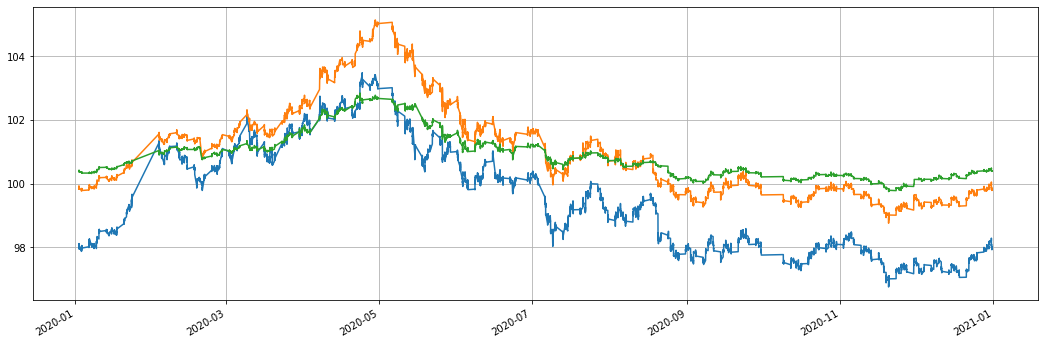

In [141]:
df2['close'].plot(figsize = (18,6),grid = True)
df5['close'].plot(figsize = (18,6),grid = True)
df10['close'].plot(figsize = (18,6),grid = True)

In [142]:
# 对原序列和一阶差分序列进行ADF检验，p值>0.05则不平稳
print(ts.adfuller(ay_close2)[1],ts.adfuller(ay_close5)[1],ts.adfuller(ay_close10)[1])
print(ts.adfuller(ay_close2_diff)[1],ts.adfuller(ay_close5_diff)[1],ts.adfuller(ay_close10_diff)[1])

0.6561124250846165 0.7110714953619884 0.7129994215207547
0.0 0.0 0.0


In [147]:
# 窗宽width
width = 60
start = 0
std_threshold = 2
initial_cash = 100000
rest_cash = 100000
fee = 3
multipilier = 10000

# N为期数
N = len(df2)

# flag1表示2年期和5年期
# flag2表示2年期和10年期
# flag3表示5年期和10年期
flag1 = np.full((N,), 0.)
flag2 = np.full((N,), 0.)
flag3 = np.full((N,), 0.)
holding2 = np.full((N,), 0.)
holding5 = np.full((N,), 0.)
holding10 = np.full((N,), 0.)
profit2 = np.full((N,), 0.)
profit5 = np.full((N,), 0.)
profit10 = np.full((N,), 0.)

price2 = df2['close'].values
price5 = df5['close'].values
price10 = df10['close'].values

long_2=long_5=short_2=short_5=None

In [148]:
weight = np.array([1-i/(100*width) for i in range(width-1,-1,-1)])

In [149]:
df_view = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index)
df_view.fillna(0,inplace=True)
count = 0

for i in range(width+1,N):
    
    holding2[i] = holding2[i - 1]
    holding5[i] = holding5[i - 1]
    holding10[i] = holding10[i - 1]
    
    if holding2[i] == 0:
        adf_r, k, b, resid = ols_reg(price2[i - width:i]*weight, price5[i - width:i]*weight)
        spread = std_threshold * np.std(resid, ddof = 1)/mean(weight)
        if price2[i] - k*price5[i] - b >= spread:
                short_2 = 1
                long_5 = 1
                count += 2
        if price2[i] - k*price5[i] - b <= -spread:
                short_5 = 1
                long_2 = 1
                count += 2
                
    elif holding2[i] != 0:
        if holding2[i] < 0:
            if abs(price2[i] - k*price5[i] - b) <= spread/2 or abs(price2[i] - k*price5[i] - b) >= 3*spread:
                long_5 = 1
                short_2 = 1
                count += 2
        elif holding2[i] > 0:
            if abs(price2[i] - k*price5[i] - b) <= spread/2 or abs(price2[i] - k*price5[i] - b) >= 3*spread:
                short_5 = 1
                long_2 = 1
                count += 2

    if holding2[i] == 0:
        if long_5 == 1 and short_2 == 1:
            profit2[i] = - fee 
            profit5[i] = - fee 
            holding2[i] = 1
            holding5[i] = -1
            long_5 = short_2 = 0
        elif short_5 == 1 and long_2 == 1:
            profit2[i] = - fee 
            profit5[i] = - fee 
            holding2[i] = -1
            holding5[i] = 1
            short_5 = long_2 = 0
    elif holding2[i] < 0:
        if long_5 == 1 and short_2 == 1:
            profit2[i] = - fee + multipilier * (price5[i - 1] - price5[i])
            profit5[i] = - fee + multipilier * (price2[i] - price2[i - 1])
            holding2[i] = 0
            holding5[i] = 0
            long_5 = short_2 = 0
        elif long_5 == 0 and short_2 == 0:
            profit2[i] = multipilier * (price5[i - 1] - price5[i])
            profit5[i] = multipilier * (price2[i] - price2[i - 1])
    elif holding2[i] > 0:
        if short_5 == 1 and long_2 == 1:
            profit2[i] = - fee + multipilier * (price5[i] - price5[i - 1])
            profit5[i] = - fee + multipilier * (price2[i - 1] - price2[i])
            holding2[i] = 0
            holding5[i] = 0
            short_5 = long_2 = 0
        elif short_5 == 0 and long_2 == 0:
            profit2[i] = multipilier * (price5[i] - price5[i - 1])
            profit5[i] = multipilier * (price2[i - 1] - price2[i])
                

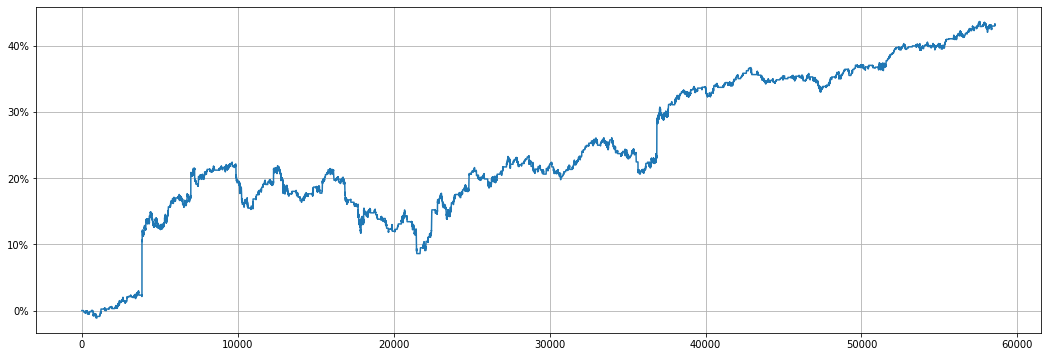

In [150]:
from matplotlib.ticker import FuncFormatter
sumprofit2 = np.cumsum(profit2)
sumprofit5 = np.cumsum(profit5)
sumprofit = sumprofit2 + sumprofit5
fig=plt.figure(figsize=(18,6))
plt.plot(sumprofit/initial_cash)
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.grid()

In [151]:
count

2340

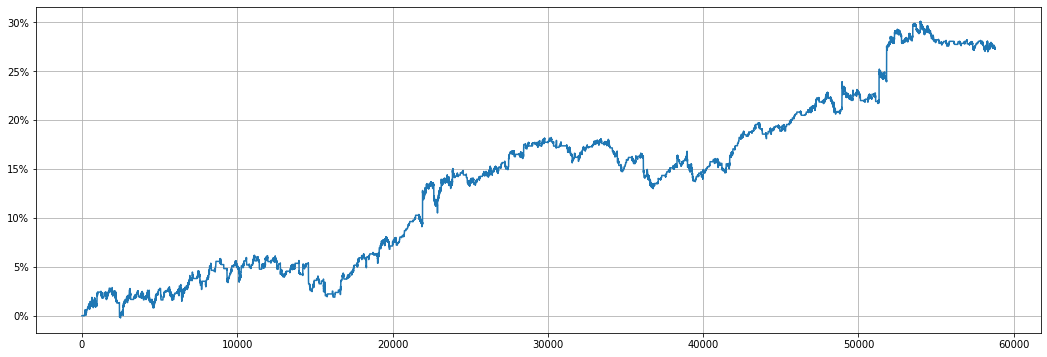

In [135]:
from matplotlib.ticker import FuncFormatter
sumprofit2 = np.cumsum(profit2)
sumprofit5 = np.cumsum(profit5)
sumprofit = sumprofit2 + sumprofit5
fig=plt.figure(figsize=(18,6))
plt.plot(sumprofit/initial_cash)
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.grid()

In [146]:
count

308

In [270]:
profit5.sum()

1581.9999999986803

In [ ]:
len(df2)

In [ ]:
df_view = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index)
df_view.fillna(0,inplace=True)

trade_all = 0
count=0
while(start + 2 * width < len(df2)):
    if(flag1+flag2+flag3 == 0):
        count += 1
        ay_close2 = np.array(df2.iloc[start:start+width]['close'])
        ay_close5 = np.array(df5.iloc[start:start+width]['close'])
        ay_close10 = np.array(df10.iloc[start:start+width]['close'])
        p_2_5 = cointegration_test2(ay_close2,ay_close5)[1]
        p_2_10 = cointegration_test2(ay_close2,ay_close10)[1]
        p_5_10 = cointegration_test2(ay_close5,ay_close10)[1]
        if(p_2_5<0.1):
            #mean_residual_2_5 = mean(ay_close2-a-b*ay_close5)
            #residual_next_2_5 = (ay_close_next2-a-b*ay_close_next5)[0] 
            #(series - series.mean()) / np.std(series)
            #XZ = zscore(ay_close_all2-a-b*ay_close_all5)
            try:
                a1,b1 = get_params(ay_close2,ay_close5)
            except:
                b1 = get_params(ay_close2,ay_close5)
                a1 = 0
            residual1 = df2.iloc[start:start+width]['close']-a1-b1*df5.iloc[start:start+width]['close']
            ratio1 = np.array((df2.iloc[start+width:start+2*width]['close']-a1-b1*df5.iloc[start+width:start+2*width]['close']-residual1.mean())/np.std(residual1))
            for temp in ratio1:
                if(temp>threshold_open):
                    location = int((np.where(abs(ratio1-temp)<0.0001))[0][0])
                    flag1 = 1
                    break
            if(flag1):
                df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x-1)
                df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x+b1)
                #df_view['2年期'][start+width+i]+=1
                #df_view['5年期'][start+width+i]-=b
                trade_all +=2
            else:
                for temp in ratio1:
                    if(temp<-threshold_open):
                        location = int((np.where(abs(ratio1-temp)<0.0001))[0][0])
                        flag1 = 1
                        break
                if(flag1):
                    df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x+1)
                    df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x-b1)
                    #df_view['2年期'][start+width+i]-=1
                    #df_view['5年期'][start+width+i]+=b
                    trade_all +=2
            
            for temp in ratio1:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio1-temp)<0.0001))[0][0])
                    flag1 = 0
                    break
            
            if(flag1 == 0):
                df_view['2年期'][start+width+location:start+2*width]=0
                df_view['5年期'][start+width+location:start+2*width]=0 

        if(p_2_10<0.1):
            try:
                a2,b2 = get_params(ay_close2,ay_close10)
            except:
                b2 = get_params(ay_close2,ay_close10)
                a2 = 0
            residual2 = df2.iloc[start:start+width]['close']-a2-b2*df10.iloc[start:start+width]['close']
            ratio2 = np.array((df2.iloc[start+width:start+2*width]['close']-a2-b2*df10.iloc[start+width:start+2*width]['close']-residual2.mean())/np.std(residual2))
            for temp in ratio2:
                if(temp>threshold_open):
                    location = int((np.where(abs(ratio2-temp)<0.0001))[0][0])
                    flag2 = 1
                    break
            if(flag2):
                df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x-1)
                df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x+b1)
                #df_view['2年期'][start+width+i]+=1
                #df_view['5年期'][start+width+i]-=b
                trade_all +=2
            else:
                for temp in ratio2:
                    if(temp<-threshold_open):
                        location = int((np.where(abs(ratio2-temp)<0.0001))[0][0])
                        flag2 = 1
                        break
                if(flag2):
                    df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x+1)
                    df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x-b1)
                    #df_view['2年期'][start+width+i]-=1
                    #df_view['5年期'][start+width+i]+=b
                    trade_all +=2

            for temp in ratio2:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio2-temp)<0.0001))[0][0])
                    flag2 = 0
                    break
            if(flag2 == 0):
                df_view['2年期'][start+width+location:start+2*width]=0
                df_view['10年期'][start+width+location:start+2*width]=0  
                
        if(p_5_10<0.1):
            try:
                a3,b3 = get_params(ay_close5,ay_close10)
            except:
                b3 = get_params(ay_close5,ay_close10)
                a3 = 0
            residual3 = df5.iloc[start:start+width]['close']-a3-b3*df10.iloc[start:start+width]['close']
            ratio3 = np.array((df5.iloc[start+width:start+2*width]['close']-a3-b3*df10.iloc[start+width:start+2*width]['close']-residual3.mean())/np.std(residual3))
            for temp in ratio3:
                if(temp>threshold_open):
                    location = int((np.where(abs(ratio3-temp)<0.0001))[0][0])
                    flag3 = 1
                    break
            if(flag3):
                df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x-1)
                df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x+b1)
                #df_view['2年期'][start+width+i]+=1
                #df_view['5年期'][start+width+i]-=b
                trade_all +=2
            else:
                for temp in ratio3:
                    if(temp<-threshold_open):
                        location = int((np.where(abs(ratio3-temp)<0.0001))[0][0])
                        flag3 = 1
                        break
                if(flag3):
                    df_view['2年期'][start+width+location:start+2*width] = df_view['2年期'][start+width+location:start+2*width].map(lambda x:x+1)
                    df_view['5年期'][start+width+location:start+2*width] = df_view['5年期'][start+width+location:start+2*width].map(lambda x:x-b1)
                    #df_view['2年期'][start+width+i]-=1
                    #df_view['5年期'][start+width+i]+=b
                    trade_all +=2
        
            for temp in ratio3:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio3-temp)<0.0001))[0][0])
                    flag3 = 0
                    break
            if(flag3 == 0):
                df_view['5年期'][start+width+location:start+2*width]=0
                df_view['10年期'][start+width+location:start+2*width]=0  
    else:
        if(flag1==1):
            residual1_new = df2.iloc[start+width:start+2*width]['close']-a1-b1*df5.iloc[start+width:start+2*width]['close']
            ratio1 = np.array((residual1_new -residual1.mean())/np.std(residual1))
            for temp in ratio1:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio1-temp)<0.001))[0][0])
                    flag1 = 0
                    break
            if(flag1 == 0):
                df_view['2年期'][start+width+location:start+2*width]=0
                df_view['5年期'][start+width+location:start+2*width]=0  
            else:
                df2.iloc[start+width:start+2*width] = df2.iloc[start:start+width]
                df5.iloc[start+width:start+2*width] = df5.iloc[start:start+width]
        if(flag2==1):
            residual2_new  = df2.iloc[start+width:start+2*width]['close']-a2-b2*df10.iloc[start+width:start+2*width]['close']
            ratio2 = np.array((residual2_new -residual2.mean())/np.std(residual2))
            for temp in ratio2:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio2-temp)<0.001))[0][0])
                    flag2 = 0
                    break
            if(flag2 == 0):
                df_view['2年期'][start+width+location:start+2*width]=0
                df_view['10年期'][start+width+location:start+2*width]=0  
            else:
                df2.iloc[start+width:start+2*width] = df2.iloc[start:start+width]
                df10.iloc[start+width:start+2*width] = df10.iloc[start:start+width]
        if(flag3==1):
            residual3_new  = df5.iloc[start+width:start+2*width]['close']-a3-b3*df10.iloc[start+width:start+2*width]['close']
            ratio3 = np.array((residual3_new -residual3.mean())/np.std(residual3))
            for temp in ratio3:
                if(temp<threshold_close and temp>-threshold_close):
                    location = int((np.where(abs(ratio3-temp)<0.001))[0][0])
                    flag3 = 0
                    break
            if(flag3 == 0):
                df_view['5年期'][start+width+location:start+2*width]=0
                df_view['10年期'][start+width+location:start+2*width]=0  
            else:
                df10.iloc[start+width:start+2*width] = df10.iloc[start:start+width]
                df5.iloc[start+width:start+2*width] = df5.iloc[start:start+width]
    if(flag1+flag2+flag3==0):
        start = start+width+location+1
    else:    
        start = start + width

In [ ]:
count

In [ ]:
trade_all

In [ ]:
df_view.to_csv("view.csv")

In [ ]:
df_history = pd.concat([df2['close'],df5['close'],df10['close']],axis=1)
df_history.columns = ['2年期','5年期','10年期']
df_rf = pd.DataFrame(np.repeat(0,len(df2)))

In [ ]:
df_view_base = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index).fillna(1/3)

In [ ]:
BT = Backtest(df_view.index, df_history, df_view, df_rf,'D',initial_asset=100)
BTM = Backtest(df_view_base.index, df_history, df_view_base, df_rf,'D',initial_asset=100)

In [26]:
display(BT.get_info(),BTM.get_info())

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,-0.015003,-0.035293,2.352317,0.009918


,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.001181,0.004207,3.561211,0.008851


In [27]:
df_result = pd.concat([pd.DataFrame(BT.df_asset),pd.DataFrame(BTM.df_asset)],axis=1)
df_result.columns=['策略','基准']
df_result.index = df2.index

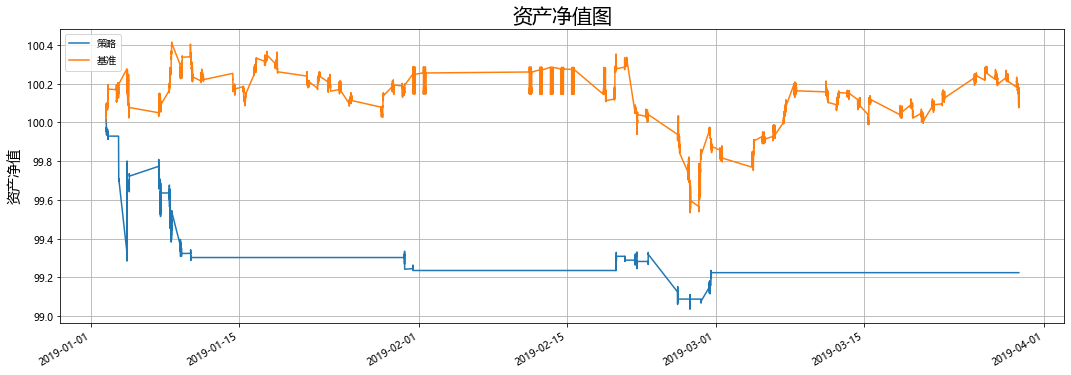

In [28]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
df_result.plot(figsize = (18,6),grid = True)
plt.title("资产净值图",fontsize=20)
plt.ylabel("资产净值",fontsize=14)
plt.show()

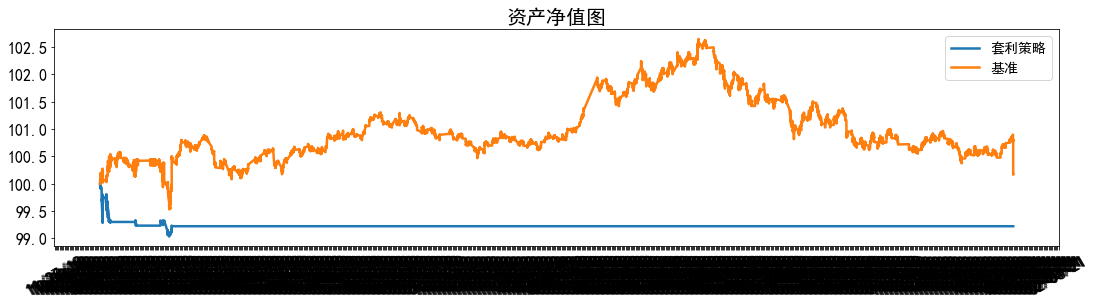

In [808]:
Plot2(df_view.index,BT.df_asset,BTM.df_asset,title="资产净值图",label1="套利策略",label2="基准")

In [702]:
df_view = pd.DataFrame(columns=['2年期','5年期','10年期'],index = df2.index)
df_view.fillna(0,inplace=True)

trade_all = 0
while(start + 2 * width < len(df2)):
    ay_close2 = np.array(df2.iloc[start:start+width]['close'])
    ay_close5 = np.array(df5.iloc[start:start+width]['close'])
    ay_close10 = np.array(df10.iloc[start:start+width]['close'])
    #ay_close_next2 = np.array(df2.iloc[start+width:start+2*width]['close'])
    #ay_close_next5 = np.array(df5.iloc[start+width:start+2*width]['close'])
    #ay_close_next10 = np.array(df10.iloc[start+width:start+2*width]['close'])
    #ay_close_all2 = np.array(df2.iloc[start:start+2*width]['close'])
    #ay_close_all5 = np.array(df5.iloc[start:start+2*width]['close'])
    #ay_close_all10 = np.array(df10.iloc[start:start+2*width]['close'])
    p_2_5 = cointegration_test2(ay_close2,ay_close5)[1]
    p_2_10 = cointegration_test2(ay_close2,ay_close10)[1]
    p_5_10 = cointegration_test2(ay_close5,ay_close10)[1]
    if(p_2_5<0.1):
        #mean_residual_2_5 = mean(ay_close2-a-b*ay_close5)
        #residual_next_2_5 = (ay_close_next2-a-b*ay_close_next5)[0] 
        #(series - series.mean()) / np.std(series)
        #XZ = zscore(ay_close_all2-a-b*ay_close_all5)
        b = get_params(ay_close2,ay_close5)
        residual = ay_close2-b*ay_close5
        ratio = ((df2.iloc[start+width]['close']-b*df5.iloc[start+width]['close'])-residual.mean())/np.std(residual)
        print(start,ratio,b)
        if(ratio>threshold): #2年期被高估
            df_view['2年期'][start+width:start+2*width] = df_view['2年期'][start+width:start+2*width].map(lambda x:x-1)
            df_view['5年期'][start+width:start+2*width] = df_view['5年期'][start+width:start+2*width].map(lambda x:x+b)
            trade_all +=2
        if(ratio<-threshold):
            df_view['2年期'][start+width:start+2*width] = df_view['2年期'][start+width:start+2*width].map(lambda x:x+1)
            df_view['5年期'][start+width:start+2*width] = df_view['5年期'][start+width:start+2*width].map(lambda x:x-b)
            trade_all +=2
    if(p_2_10<0.1):
        b = get_params(ay_close_all2,ay_close_all10)
        residual = ay_close2-b*ay_close10
        ratio = ((df2.iloc[start+width]['close']-b*df10.iloc[start+width]['close'])-residual.mean())/np.std(residual)
        if(ratio>threshold):
            df_view['2年期'][start+width:start+2*width] = df_view['2年期'][start+width:start+2*width].map(lambda x:x-1)
            df_view['10年期'][start+width:start+2*width] = df_view['10年期'][start+width:start+2*width].map(lambda x:x+b)
            trade_all +=2
        if(ratio<-threshold):
            df_view['2年期'][start+width:start+2*width] = df_view['2年期'][start+width:start+2*width].map(lambda x:x+1)
            df_view['10年期'][start+width:start+2*width] = df_view['10年期'][start+width:start+2*width].map(lambda x:x-b)
            trade_all +=2
    if(p_5_10<0.1):
        b = get_params(ay_close_all5,ay_close_all10)
        residual = ay_close5-b*ay_close10
        ratio = ((df5.iloc[start+width]['close']-b*df10.iloc[start+width]['close'])-residual.mean())/np.std(residual)
        if(ratio>threshold):
            df_view['5年期'][start+width:start+2*width] = df_view['5年期'][start+width:start+2*width].map(lambda x:x-1)
            df_view['10年期'][start+width:start+2*width] = df_view['10年期'][start+width:start+2*width].map(lambda x:x+b)
            trade_all +=2
        if(ratio<-threshold):
            df_view['5年期'][start+width:start+2*width] = df_view['5年期'][start+width:start+2*width].map(lambda x:x+1)
            df_view['10年期'][start+width:start+2*width] = df_view['10年期'][start+width:start+2*width].map(lambda x:x-b)
            trade_all +=2
    start = start + width